In [1]:
import json
import os
import sys
import glob
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append(os.path.join(sys.path[0], '../tooling/'))
from myeval import myevaluatemodels
from mymodels import cascade_classifier

Collect statistics

In [3]:
location = '../results/train_vj/'
load_dirs = glob.glob(os.path.join(location,'*.json'))

In [4]:
params = [name[32:-11] for name in load_dirs]
stages = np.sort(np.unique([name[:name.find("_")] for name in params]).astype('float64'))
alarms = np.sort(np.unique([name[1+name.find("_"):] for name in params]).astype('float64'))

In [5]:
train_scores = np.zeros([alarms.shape[0],stages.shape[0]])
val_scores = np.zeros_like(train_scores)
for i, alarm in enumerate(alarms):
    for j, stage in enumerate(stages):
        model = 'ballcascade_' + str(round(stage)) + '_' + str(alarm)
        dir = location + model + '_stats.json'
        with open(dir, 'r') as input_file:
            read_dict = json.load(input_file)
        if "coco_train_sml_01_False_matchdrill" in read_dict[model]:
            train_scores[i,j] = read_dict[model]['coco_train_sml_01_False_matchdrill']['AP_{@[IoU=0.50:0.95]-all}'] 
        if "coco_validation_sml_01_False_matchdrill" in read_dict[model]:
            val_scores[i,j] = read_dict[model]['coco_validation_sml_01_False_matchdrill']['AP_{@[IoU=0.50:0.95]-all}']        

Plot all detectors

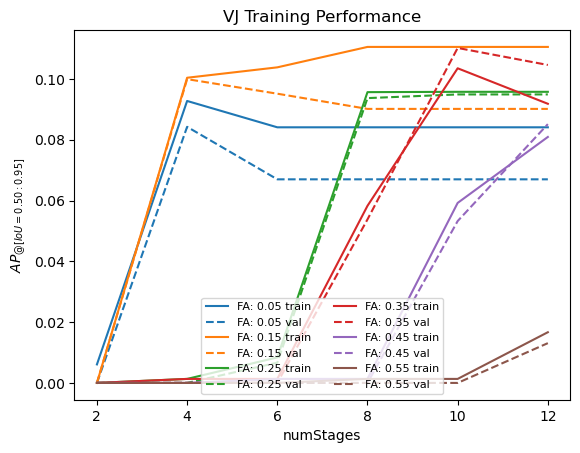

In [6]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
leg_list = []
for i, train_score in enumerate(train_scores):
    plt.plot(stages, train_scores[i], linestyle='-', color=colors[i])
    leg_list.append("FA: " + str(alarms[i]) + " train")
    plt.plot(stages, val_scores[i], linestyle='--', color=colors[i])
    leg_list.append("FA: " + str(alarms[i])+ " val")

plt.legend(leg_list, loc="lower center", fontsize="8", ncol=2)
plt.xlabel("numStages")
plt.ylabel("$" + "AP_{@[IoU=0.50:0.95]}" + "$")
plt.title("VJ Training Performance")
plt.show()

Fine tune

In [7]:
%%capture 
neighbours = np.arange(1,6).astype('int8')
tune_scores = np.zeros(neighbours.shape[0])
chosen_model = '../models/vj/ballcascade_10_0.35.xml'
dataset = "../data/coco_validation_sml_01_False_matchdrill/"
result_dir = "./"

for i, neighbour in enumerate(neighbours):
    evaluate_model = [[chosen_model, cascade_classifier, {"scale_factor":1.1, "min_neighbours":neighbour}]]
    evaluate_dataset = [dataset]
    myevaluatemodels(evaluate_model, evaluate_dataset, result_dir, verbose=False)
    result_name = chosen_model[13:-4]+'_stats.json'
    with open(result_name, 'r') as input_file:
        result_dict = json.load(input_file)
    tune_scores[i] = result_dict[chosen_model[13:-4]][dataset[8:-1]]['AP_{@[IoU=0.50:0.95]-all}'] 
    print(tune_scores)
        
os.remove(result_name)


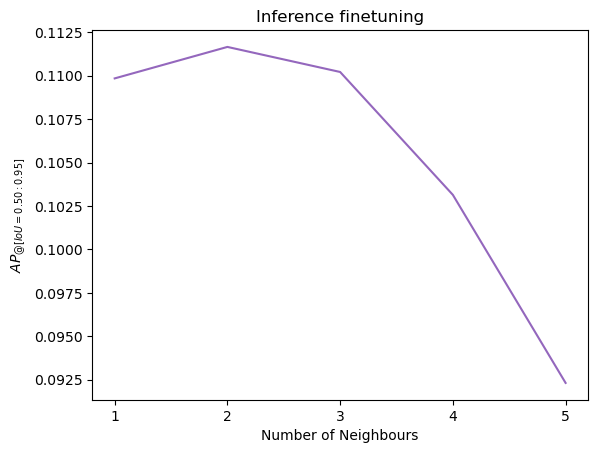

In [8]:
plt.plot(neighbours, tune_scores, linestyle='-', color=colors[i])
plt.xlabel("Number of Neighbours")
plt.xticks(neighbours)
plt.ylabel("$" + "AP_{@[IoU=0.50:0.95]}" + "$")
plt.title("Inference finetuning")
plt.show()

Ablation study

array([1.02, 1.04, 1.06, 1.08, 1.1 ])

In [23]:
%%capture 
scales = np.linspace(1, 1.1, 6)[1:]
speed_scores = np.zeros(scales.shape[0])
speed_lats = np.zeros(scales.shape[0])
chosen_model = '../models/vj/ballcascade_10_0.35.xml'
dataset = "../data/coco_validation_sml_01_False_matchdrill/"
result_dir = "./"

for i, scale in enumerate(scales):
    evaluate_model = [[chosen_model, cascade_classifier, {"scale_factor":scale, "min_neighbours":2}]]
    evaluate_dataset = [dataset]
    myevaluatemodels(evaluate_model, evaluate_dataset, result_dir, verbose=False)
    result_name = chosen_model[13:-4]+'_stats.json'
    with open(result_name, 'r') as input_file:
        result_dict = json.load(input_file)
    speed_scores[i] = result_dict[chosen_model[13:-4]][dataset[8:-1]]['AP_{@[IoU=0.50:0.95]-all}'] 
    speed_lats[i] = result_dict[chosen_model[13:-4]][dataset[8:-1]]['latency'] 
        
os.remove(result_name)

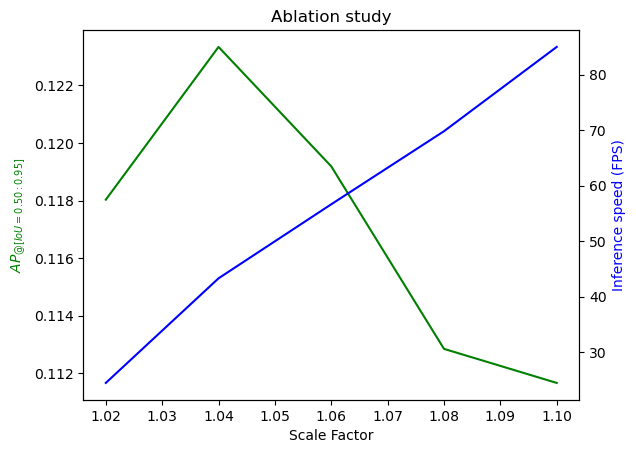

In [24]:
fig, ax1 = plt.subplots()
plt.title("Ablation study")

ax2 = ax1.twinx()
ax1.plot(scales, speed_scores, 'g-')
ax2.plot(scales, speed_lats, 'b-')

ax1.set_xlabel('Scale Factor')
ax1.set_ylabel('$' + 'AP_{@[IoU=0.50:0.95]}' + '$', color='g')
ax2.set_ylabel('Inference speed (FPS)', color='b')

plt.show()